In [ ]:
# Reproducibility: fix all random seeds
import os
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)  # explicitly OFF — strict mode crashes on Colab CUDA
print(f"All random seeds set to {SEED}")

# --- Mount Google Drive early so ALL cells can find cached files ---
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_FOLDER = "/content/drive/MyDrive/GNN测试"
    os.makedirs(DRIVE_FOLDER, exist_ok=True)
    os.chdir(DRIVE_FOLDER)
    print(f"Colab: working directory set to {DRIVE_FOLDER}")

    # Pull scripts from GitHub (code lives on GitHub, data on Drive)
    REPO_URL = "https://github.com/hryxx86/GNN-Testing.git"
    REPO_DIR = "/content/GNN-Testing"
    if os.path.exists(REPO_DIR):
        os.system(f"cd {REPO_DIR} && git pull -q")
    else:
        os.system(f"git clone -q {REPO_URL} {REPO_DIR}")
    # Symlink scripts/ and docs/ from repo into Drive working directory
    for folder in ["scripts", "docs"]:
        link = os.path.join(DRIVE_FOLDER, folder)
        target = os.path.join(REPO_DIR, folder)
        if not os.path.exists(link) and os.path.exists(target):
            os.symlink(target, link)
            print(f"  Linked {folder}/ from GitHub repo")
except ImportError:
    from pathlib import Path
    notebook_dir = Path("/Users/heruixi/Desktop/GNN-Testing")
    os.chdir(notebook_dir)
    print(f"Local: working directory set to {notebook_dir}")

# -----------------------------------------------------------
import requests
import pandas as pd
import yfinance as yf

# Ensure data directory exists
os.makedirs("data", exist_ok=True)

# Define the filename
FILE_NAME = "data/sp500_5y_prices.csv"

# Logic: Load local file if exists, otherwise download
if os.path.exists(FILE_NAME):
    print(f"Local file '{FILE_NAME}' found. Loading data...")
    prices = pd.read_csv(FILE_NAME, index_col=0)
else:
    print("Local file not found. Starting download pipeline...")
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    tickers = pd.read_html(html)[0]['Symbol'].str.replace('.', '-', regex=False).tolist()

    print(f"Downloading {len(tickers)} stocks...")
    data = yf.download(tickers, period="5y", auto_adjust=True)

    prices = data['Close'] if 'Close' in data.columns else data
    prices = prices.dropna(axis=1, how='all')
    prices.to_csv(FILE_NAME)
    print("Download complete and saved.")

print(f"Data ready. Shape: {prices.shape}")

In [ ]:
#Save plots function
import os
import matplotlib.pyplot as plt

def save_graph(filename, folder="plots"):
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    path = f"{folder}/{filename}.png"
    plt.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Image saved successfully to: {path}")

In [ ]:
# if running with Colab GPU 
!pip install --quiet torch_geometric -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

import torch
from torch_geometric.nn import GCNConv

# --- 1. Load Data & Preprocess ---
# Read the CSV file we just downloaded
df = pd.read_csv("data/sp500_5y_prices.csv", index_col=0)
# Calculate daily returns (Change from yesterday)
returns = df.pct_change().dropna()

# --- 2. Build Graph (The "Structure") ---
# Calculate Correlation Matrix (How similar are the stocks?)
# .T ensures stocks are columns for corr computation if needed, but usually df structure is (Date, Ticker)
corr_matrix = torch.tensor(returns.corr().values)

# Define Edges: Connect stocks if absolute correlation > 0.6
# This creates the "Adjacency Matrix" in sparse format
edge_index = (corr_matrix.abs() > 0.6).nonzero().t()

# --- 3. Define Minimalist GCN Model ---
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super().__init__()
        # Layer 1: Look at immediate neighbors
        self.conv1 = GCNConv(in_features, hidden_dim)
        # Layer 2: Look at neighbors of neighbors
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        # Layer 1 -> ReLU Activation (Non-linearity)
        x = self.conv1(x, edge_index).relu()
        # Layer 2 -> Final Output
        x = self.conv2(x, edge_index)
        return x

# --- 4. Execution (Run the model) ---
# Prepare Input Features (Node Features)
# We take the VERY LAST day's returns as input. Shape: [Num_Stocks, 1]
x = torch.tensor(returns.iloc[-1].values, dtype=torch.float).view(-1, 1)

# Initialize Model (1 Input -> 16 Hidden -> 1 Output)
model = GCN(in_features=1, hidden_dim=16, out_features=1)

# Forward Pass 
output = model(x, edge_index)

# --- 5. Report ---
print("-" * 30)
print(f"Graph Statistics:")
print(f"  - Nodes (Stocks): {x.shape[0]}")
print(f"  - Edges (Connections): {edge_index.shape[1]}")
print(f"  - Edge Density: {edge_index.shape[1] / (x.shape[0]**2):.4f}")
print("\nModel Architecture:")
print(model)
print(f"\nOutput Shape: {output.shape}") # Should be [Num_Stocks, 1]
print("Success: GCN forward pass completed.")
print("-" * 30)

In [ ]:
# Fetch & cache market cap data for all S&P 500 stocks
import yfinance as yf

MCAP_FILE = "data/sp500_market_caps.csv"

if os.path.exists(MCAP_FILE):
    print(f"Local file '{MCAP_FILE}' found. Loading market cap data...")
    market_caps = pd.read_csv(MCAP_FILE, index_col=0).squeeze()
else:
    print("Downloading market cap data from yfinance (this may take 5-10 minutes)...")
    ticker_names_all = returns.columns.tolist()
    caps = {}
    for i, tk in enumerate(ticker_names_all):
        try:
            info = yf.Ticker(tk).info
            caps[tk] = info.get("marketCap", 0) or 0
        except Exception:
            caps[tk] = 0
        if (i + 1) % 50 == 0:
            print(f"  Progress: {i + 1}/{len(ticker_names_all)}")
    market_caps = pd.Series(caps, name="MarketCap")
    market_caps.to_csv(MCAP_FILE)
    print(f"Saved to {MCAP_FILE}")

print(f"Market cap data ready. Non-zero entries: {(market_caps > 0).sum()}/{len(market_caps)}")
print("Top 5 by market cap:")
print(market_caps.nlargest(5))

In [ ]:
# Fetch & cache GICS sector data from Wikipedia
import requests

SECTOR_FILE = "data/sp500_sectors.csv"

if os.path.exists(SECTOR_FILE):
    print(f"Local file '{SECTOR_FILE}' found. Loading sector data...")
    sector_map = pd.read_csv(SECTOR_FILE, index_col=0).squeeze().to_dict()
else:
    print("Downloading sector data from Wikipedia...")
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    html = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text
    sp500_table = pd.read_html(html)[0]
    sp500_table['Symbol'] = sp500_table['Symbol'].str.replace('.', '-', regex=False)
    sector_series = sp500_table.set_index('Symbol')['GICS Sector']
    sector_series.to_csv(SECTOR_FILE)
    sector_map = sector_series.to_dict()
    print(f"Saved to {SECTOR_FILE}")

print(f"Sector data ready. {len(sector_map)} tickers mapped.")
print("Sectors:", sorted(set(sector_map.values())))

Image saved successfully to: plots/S&P 500 Correlation Network (Top 100 Market Cap).png


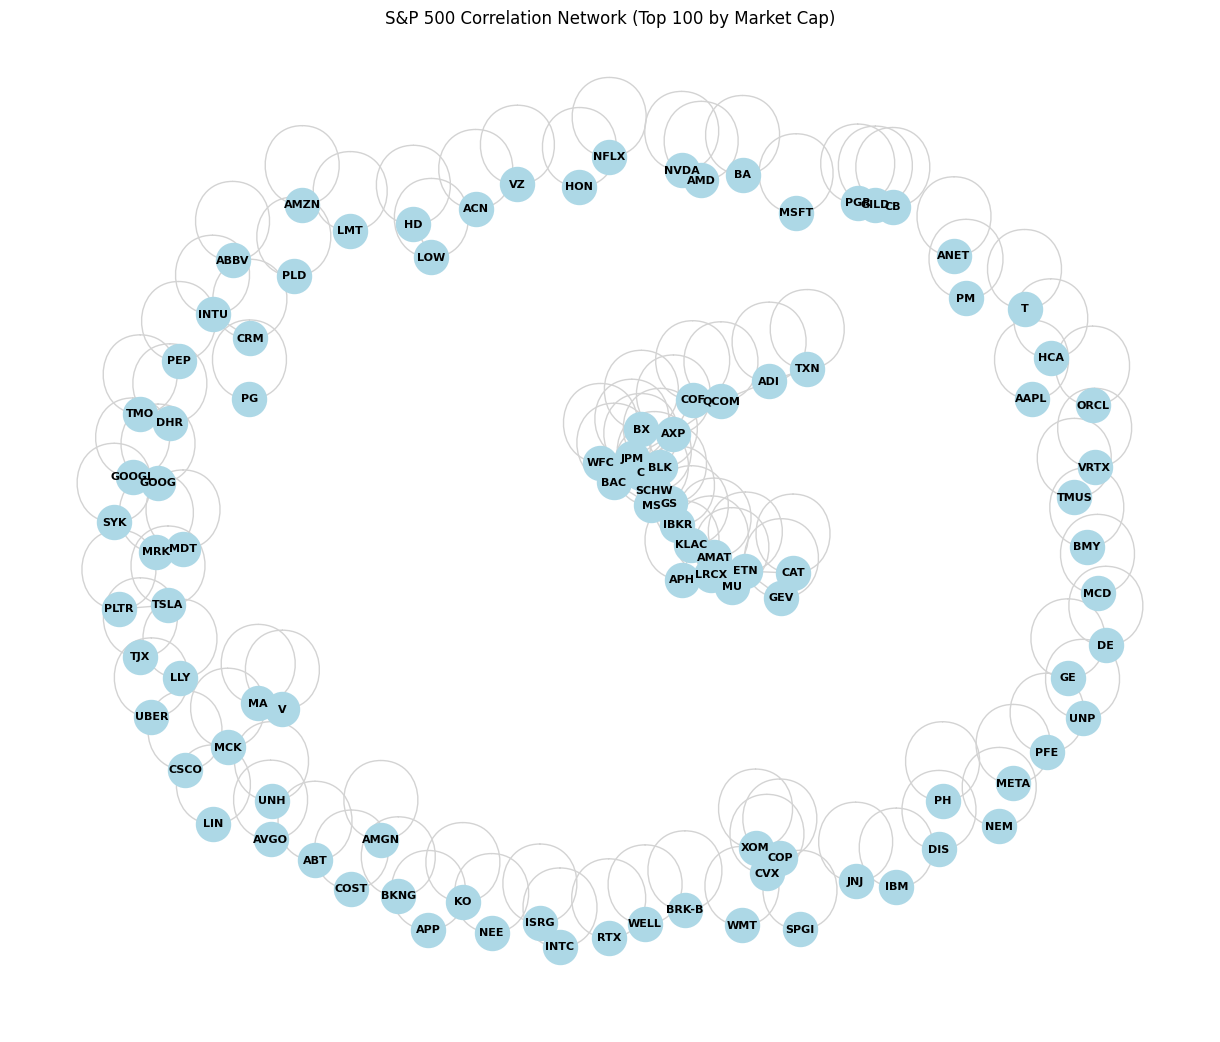

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Top 100 stocks by market cap
ticker_names = returns.columns.tolist()

# Get top 100 tickers by market cap, then map to their column index in returns
top100_tickers = market_caps.reindex(ticker_names).nlargest(100).index.tolist()
top100_indices = [ticker_names.index(tk) for tk in top100_tickers]

# Filter edges: keep only edges where BOTH endpoints are in the top 100
sub_nodes = top100_indices
node_set = torch.tensor(sub_nodes)
sub_edges = edge_index[:, torch.isin(edge_index[0], node_set) & torch.isin(edge_index[1], node_set)]

# Build graph
g = nx.Graph()
g.add_nodes_from(sub_nodes)
g.add_edges_from(sub_edges.t().tolist())

# Label mapping (index -> ticker name)
label_map = {i: ticker_names[i] for i in sub_nodes}

# Plot
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(g, seed=42, k=0.15)

nx.draw(g, pos,
        node_size=600,
        node_color='lightblue',
        edge_color='lightgray',
        with_labels=True,
        labels=label_map,
        font_size=8,
        font_weight='bold')

plt.title(f"S&P 500 Correlation Network (Top 100 by Market Cap)")
save_graph("S&P 500 Correlation Network (Top 100 Market Cap)")
plt.show()

/tmp/ipython-input-2338194319.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_sectors))


Image saved successfully to: plots/S&P 500 Top 100 Sector Colored.png


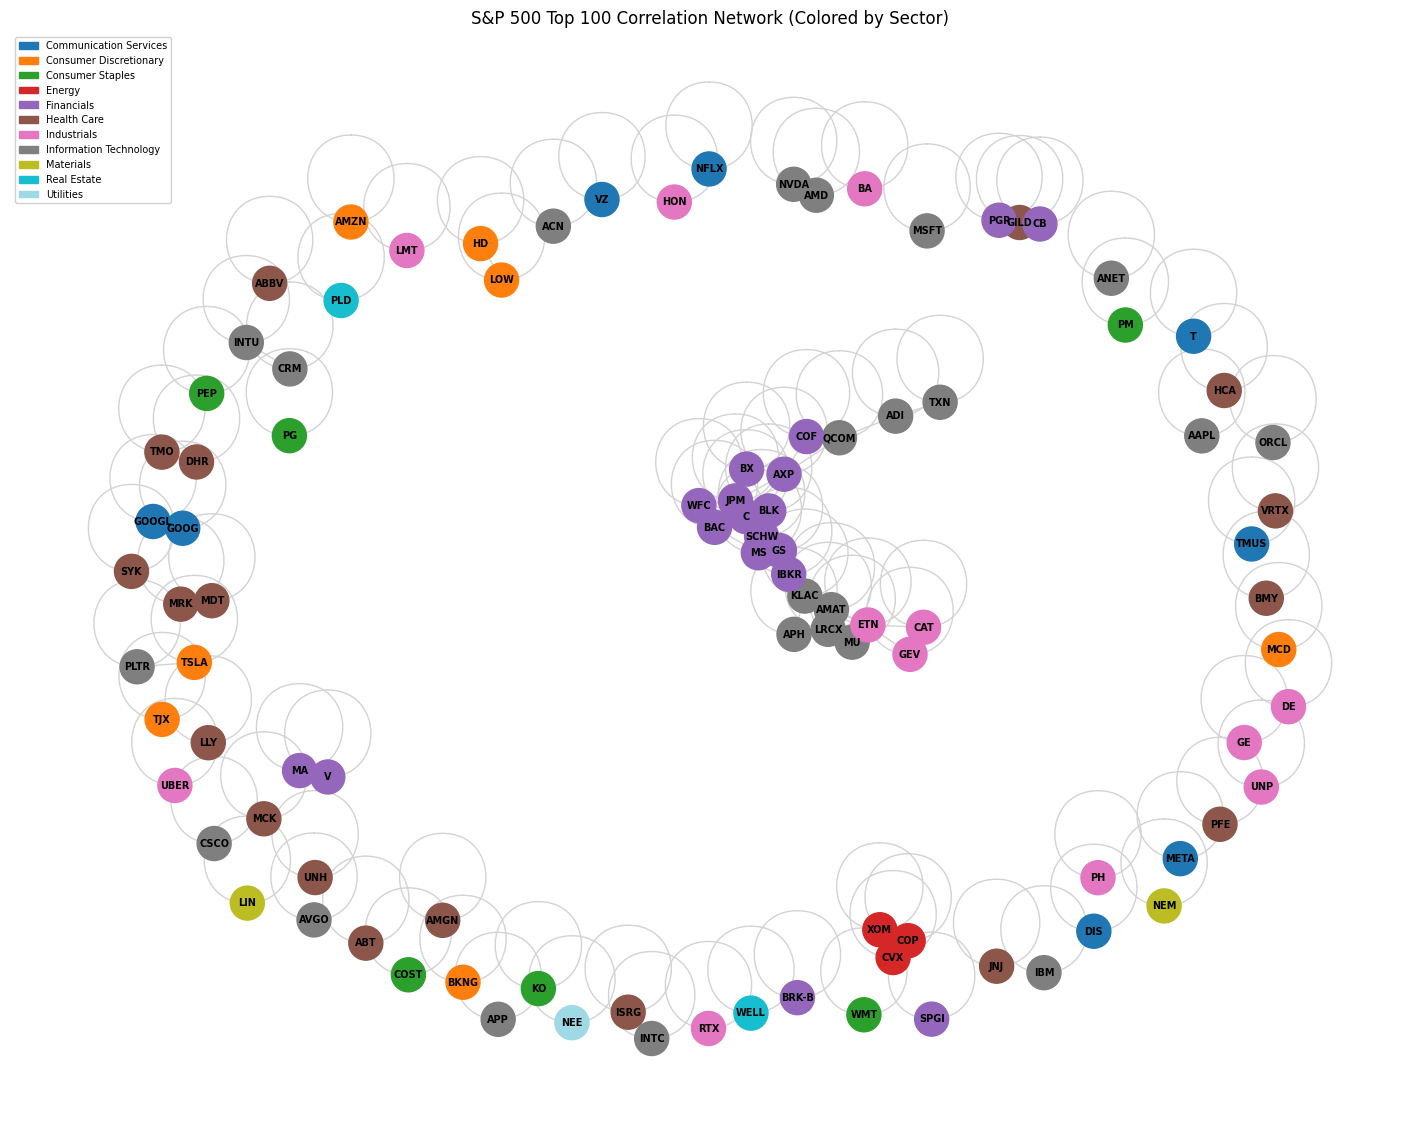

In [8]:
# Top 100 by Market Cap — Colored by GICS Sector
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ticker_names = returns.columns.tolist()

# Reuse top 100 by market cap
top100_tickers = market_caps.reindex(ticker_names).nlargest(100).index.tolist()
top100_indices = [ticker_names.index(tk) for tk in top100_tickers]

# Filter edges
node_set = torch.tensor(top100_indices)
sub_edges = edge_index[:, torch.isin(edge_index[0], node_set) & torch.isin(edge_index[1], node_set)]

# Build graph
g = nx.Graph()
g.add_nodes_from(top100_indices)
g.add_edges_from(sub_edges.t().tolist())

# Assign sectors and colors
label_map = {i: ticker_names[i] for i in top100_indices}
sectors = [sector_map.get(ticker_names[i], "Unknown") for i in top100_indices]
unique_sectors = sorted(set(sectors))
cmap = plt.cm.get_cmap("tab20", len(unique_sectors))
sector_to_color = {s: cmap(j) for j, s in enumerate(unique_sectors)}
node_colors = [sector_to_color[s] for s in sectors]

# Plot
plt.figure(figsize=(14, 11))
pos = nx.spring_layout(g, seed=42, k=0.15)

nx.draw(g, pos,
        node_size=600,
        node_color=node_colors,
        edge_color='lightgray',
        with_labels=True,
        labels=label_map,
        font_size=7,
        font_weight='bold')

# Legend
patches = [mpatches.Patch(color=sector_to_color[s], label=s) for s in unique_sectors]
plt.legend(handles=patches, loc='upper left', fontsize=7, framealpha=0.9)

plt.title("S&P 500 Top 100 Correlation Network (Colored by Sector)")
save_graph("S&P 500 Top 100 Sector Colored")
plt.show()

Image saved successfully to: plots/sp500_all_corr.png


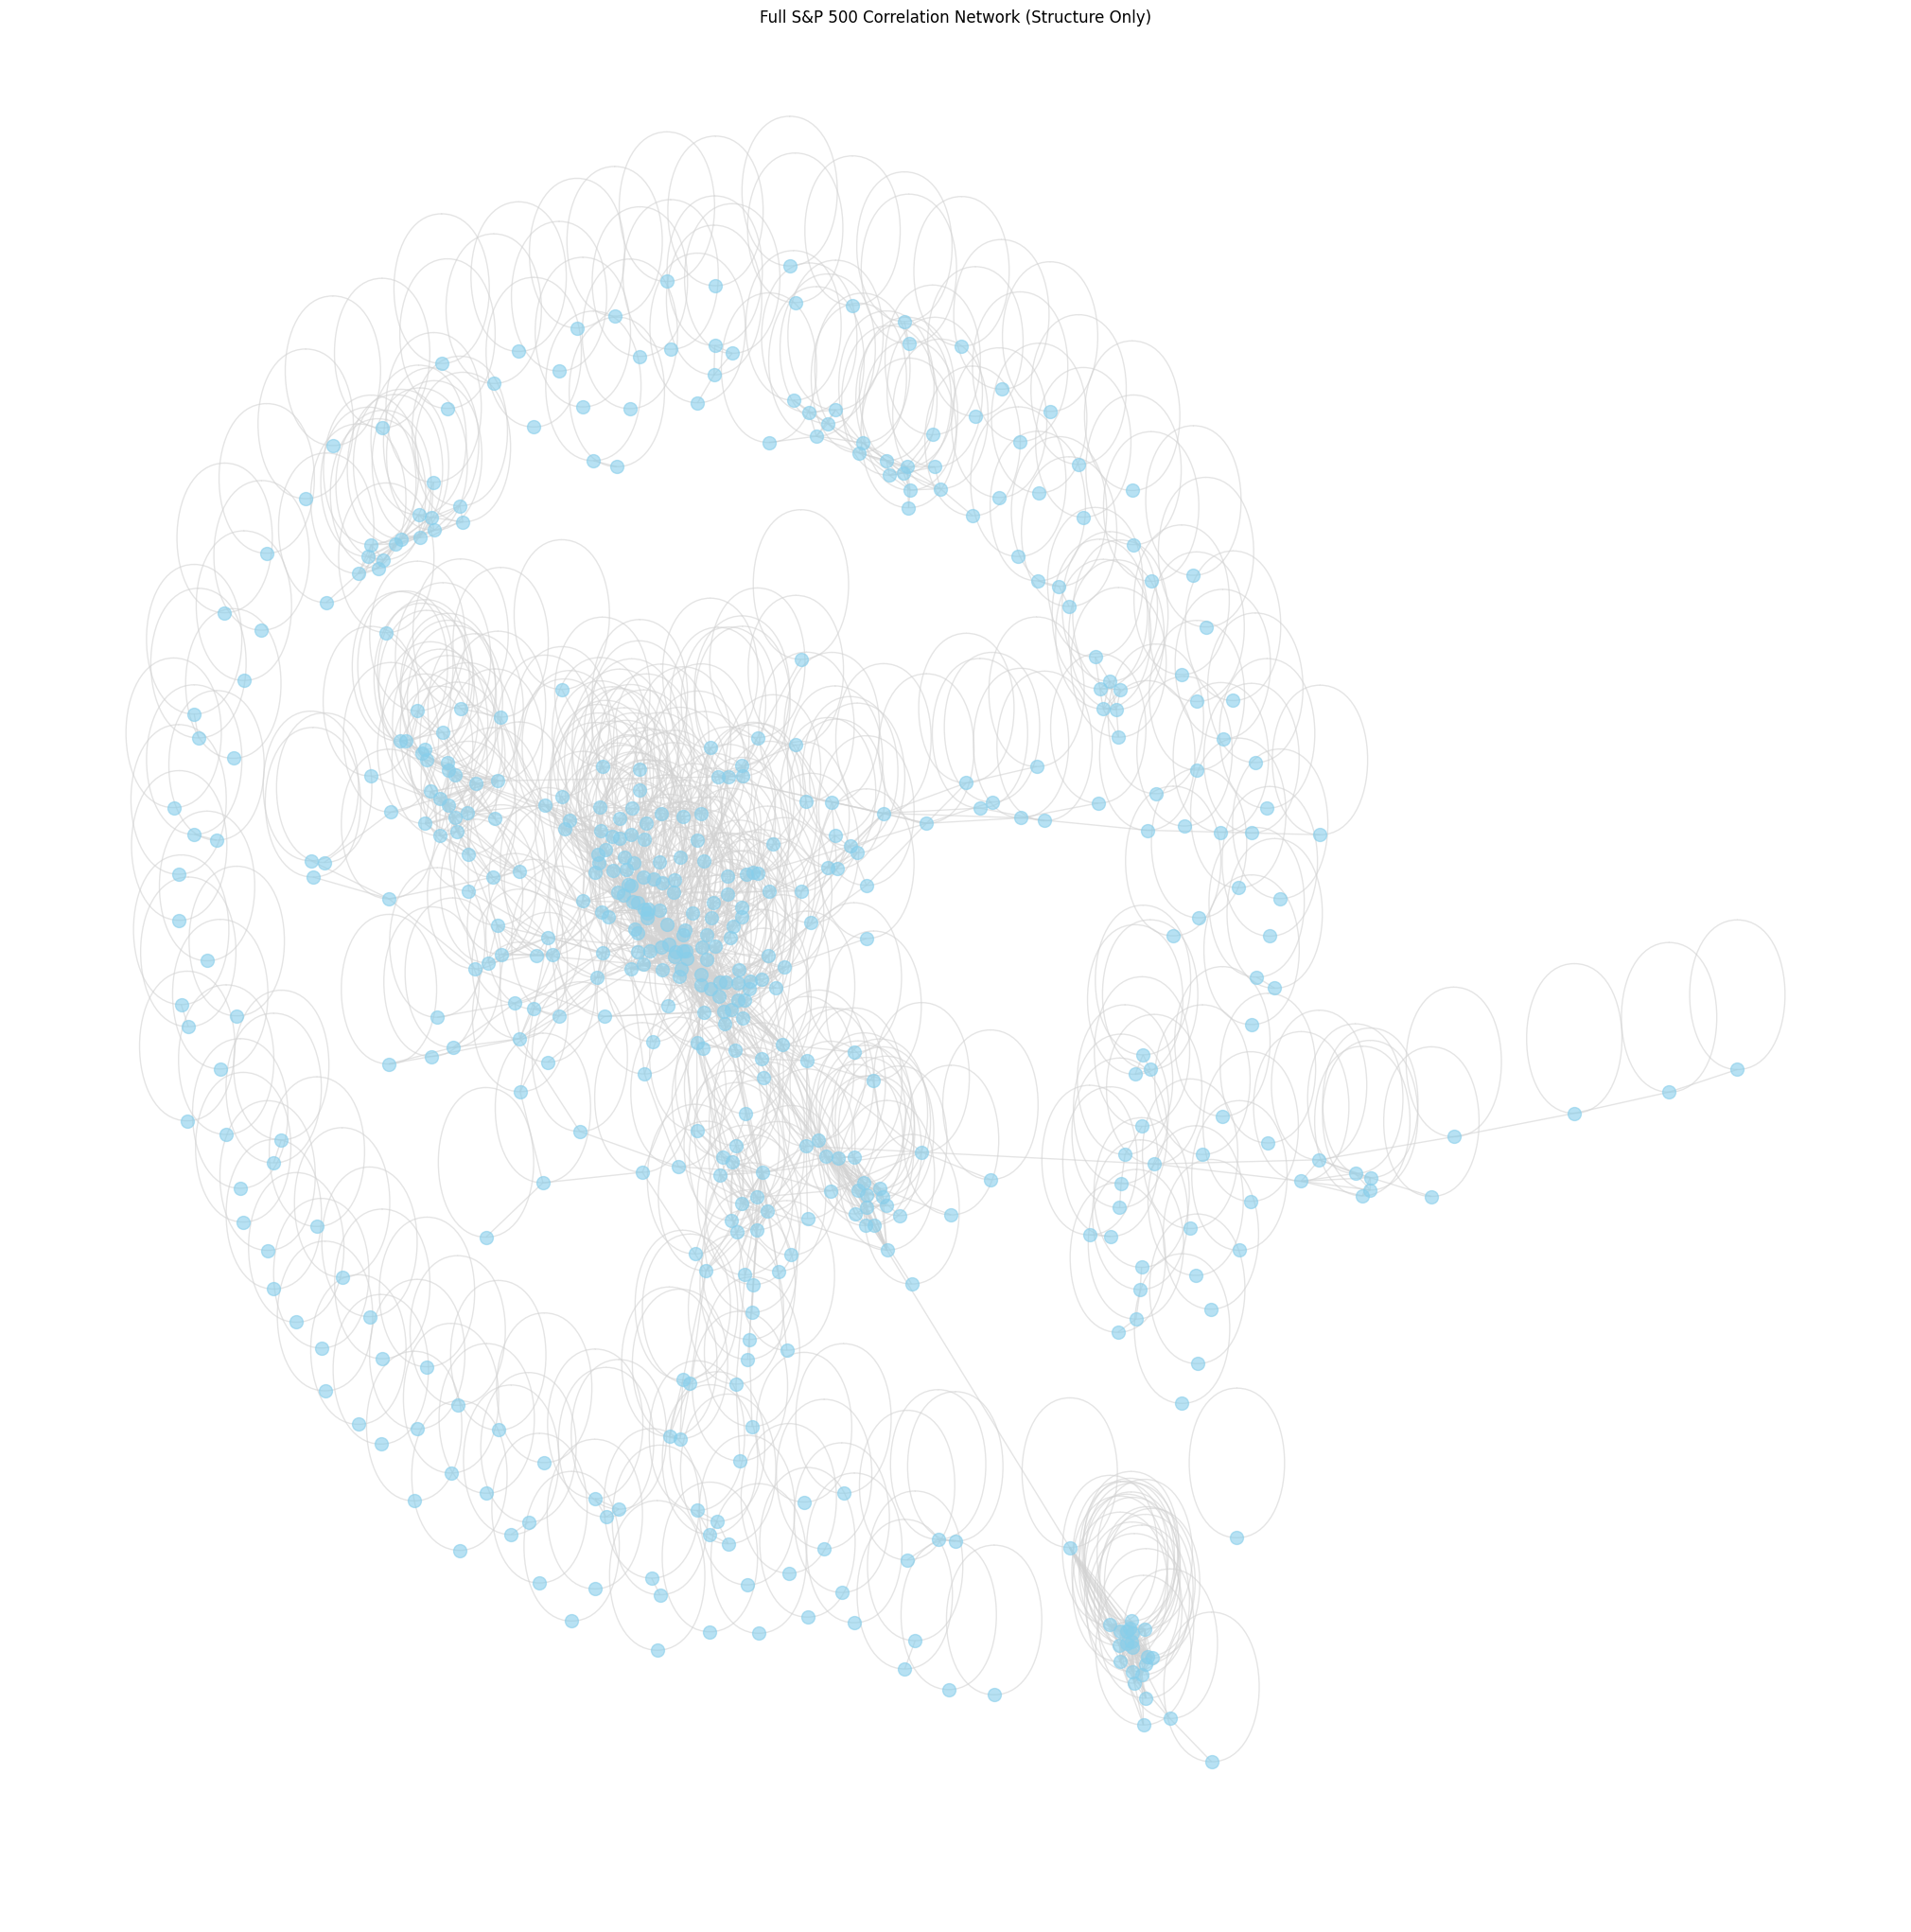

In [9]:
# All Stocks
all_nodes = range(len(returns.columns))
all_edges = edge_index # No filtering needed

# --- Build Graph ---
g = nx.Graph()
g.add_nodes_from(all_nodes)
g.add_edges_from(all_edges.t().tolist())

# --- Map Labels ---
ticker_names = returns.columns.tolist()
label_map = {i: ticker_names[i] for i in all_nodes}

# --- Plot ---
plt.figure(figsize=(20, 20)) # Must increase canvas size drastically!
# k=0.05: Make nodes pull tighter together to fit in screen
pos = nx.spring_layout(g, seed=42, k=0.05) 

nx.draw(g, pos, 
        node_size=100, # Make nodes smaller
        node_color='skyblue', 
        edge_color='lightgray', 
        with_labels=False, # Turn OFF labels (too messy for 500 nodes)
        alpha=0.6)

plt.title("Full S&P 500 Correlation Network (Structure Only)")
save_graph("sp500_all_corr")
plt.show()

Top 10 Most Connected Stocks (The Market Hubs):
1. SWK (Connections: 50)
2. ITW (Connections: 39)
3. MAS (Connections: 36)
4. DOV (Connections: 33)
5. TFC (Connections: 32)
6. IR (Connections: 32)
7. ODFL (Connections: 31)
8. CFG (Connections: 31)
9. RF (Connections: 30)
10. WAB (Connections: 30)
Image saved successfully to: plots/top10_hubs_network.png


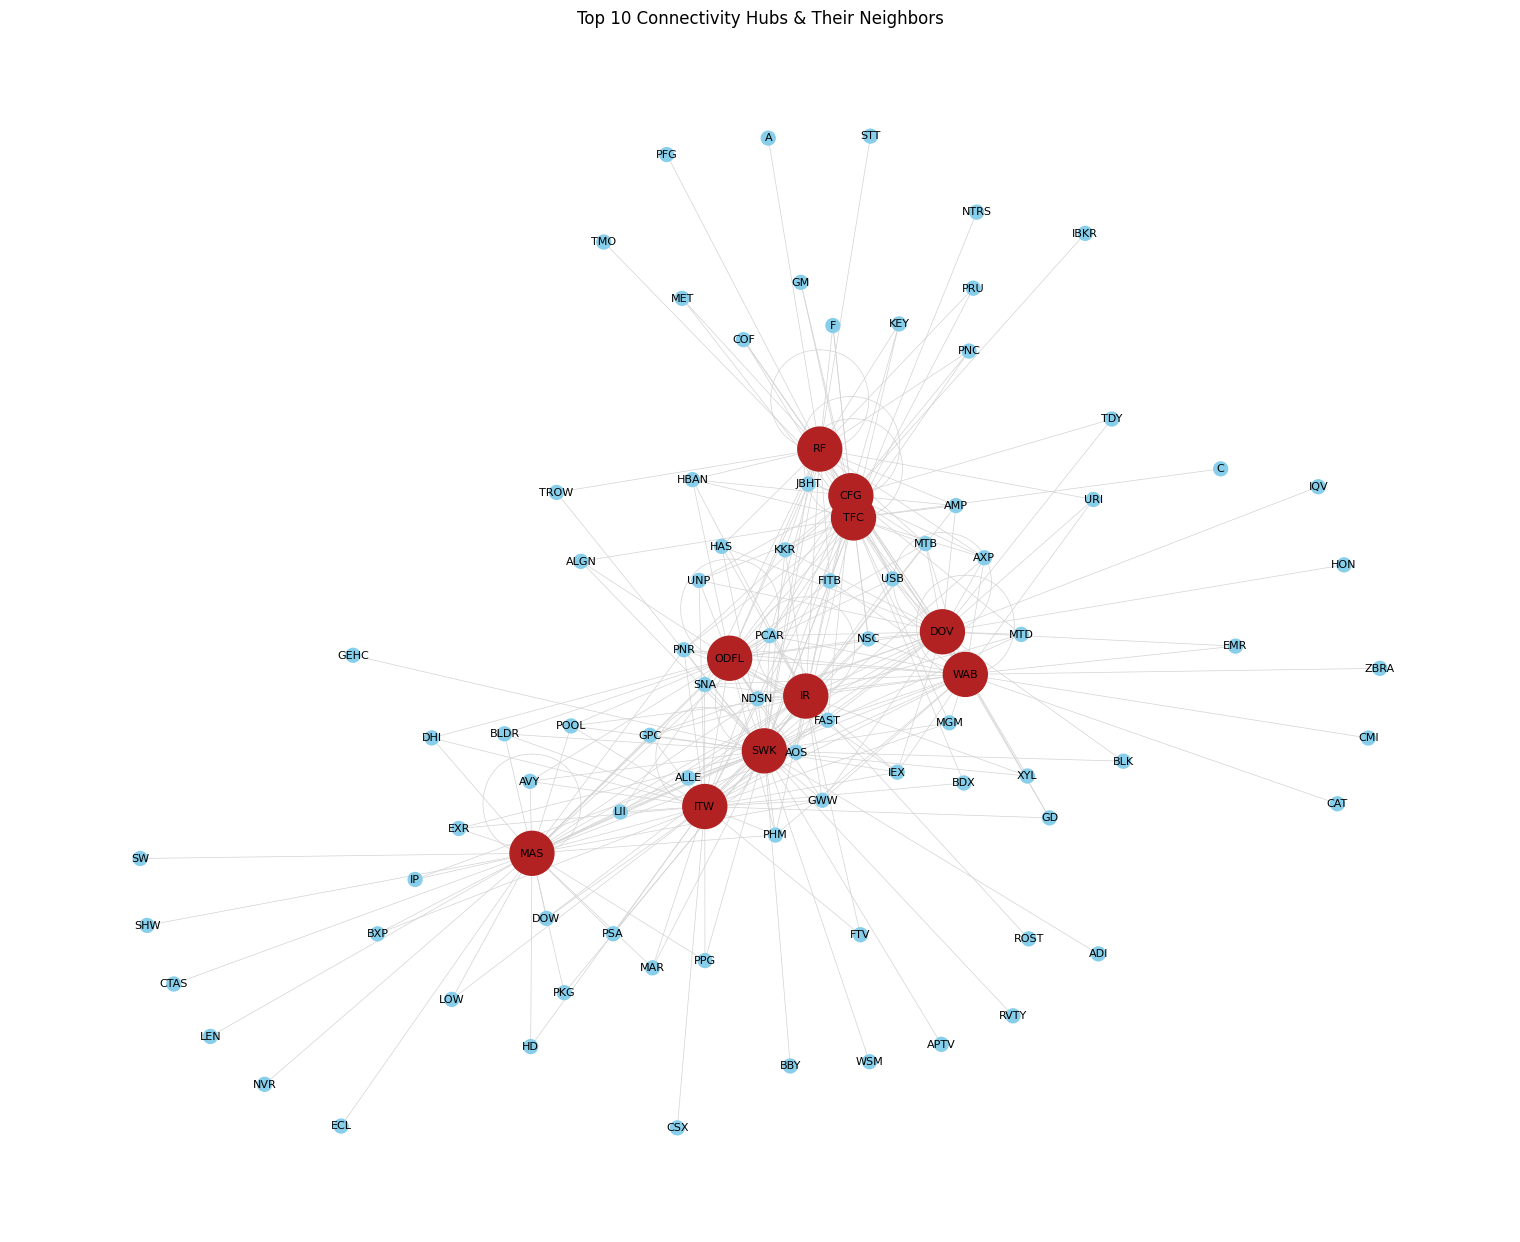

In [10]:
#Top 10 "Hub" Stocks

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import degree

# Calculate degree (number of edges) for each node
d = degree(edge_index[0], dtype=torch.long)

# Get indices of the top 10 highest degree nodes
k = 10
top_values, top_nodes_tensor = torch.topk(d, k)
top_nodes = top_nodes_tensor.tolist()

# Print who they are
ticker_names = returns.columns.tolist()
print("Top 10 Most Connected Stocks (The Market Hubs):")
for i, idx in enumerate(top_nodes):
    print(f"{i+1}. {ticker_names[idx]} (Connections: {top_values[i].item()})")

# --- 2. Extract Subgraph (Top 10 + Their Neighbors) ---
# We keep an edge if EITHER source OR target is in the Top 10
mask = torch.isin(edge_index[0], top_nodes_tensor) | \
       torch.isin(edge_index[1], top_nodes_tensor)

sub_edges = edge_index[:, mask]

# Get all unique nodes in this subgraph (Hubs + Neighbors)
unique_nodes = torch.unique(sub_edges).tolist()

# --- 3. Visualization Setup ---
g = nx.Graph()
g.add_nodes_from(unique_nodes)
g.add_edges_from(sub_edges.t().tolist())

# Map ID to Ticker
label_map = {i: ticker_names[i] for i in unique_nodes}

# Define Colors & Sizes based on role
# Red/Large for Top 10, Blue/Small for others
node_colors = ['firebrick' if i in top_nodes else 'skyblue' for i in unique_nodes]
node_sizes = [1000 if i in top_nodes else 100 for i in unique_nodes]

# --- 4. Plot ---
plt.figure(figsize=(15, 12))
# Use Kamada-Kawai layout (good for visualizing central hubs)
pos = nx.spring_layout(g, seed=42, k=0.15)

nx.draw(g, pos, 
        node_color=node_colors, 
        node_size=node_sizes, 
        with_labels=True, 
        labels=label_map,
        edge_color='lightgray',
        font_size=8,
        width=0.5)

plt.title(f"Top {k} Connectivity Hubs & Their Neighbors")
save_graph("top10_hubs_network")
plt.show()

Embedding Shape: (502, 16)
Image saved successfully to: plots/gnn_tsne_embedding.png


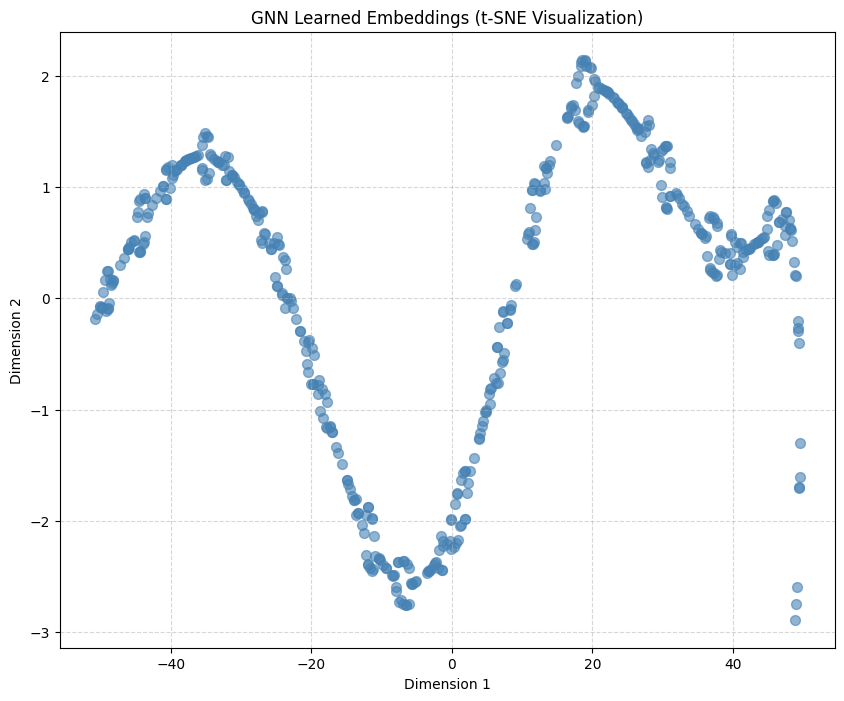

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract Embeddings (The "Brain" State)
# We want the output of the FIRST layer (16-dimensional), not the final prediction
# Detach removes it from the computational graph so we can plot it
embeddings = model.conv1(x, edge_index).detach().numpy()

print(f"Embedding Shape: {embeddings.shape}") # Should be (502, 16)

# 2. Reduce Dimensions (16D -> 2D) using t-SNE
# perplexity=30 is standard. It determines how many neighbors to consider.
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Visualization
plt.figure(figsize=(10, 8))
# Plot all points
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50, c='steelblue')

# Optional: Annotate a few famous tech stocks if they are in the list
# (This assumes you know their index, for now we just plot the structure)
plt.title("GNN Learned Embeddings (t-SNE Visualization)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)
save_graph("gnn_tsne_embedding")
plt.show()

In [ ]:
# Phase B: Dynamic Graph Construction & Sensitivity Analysis
# Uses build_dynamic_graphs.py module — swap graph method or params via config

import sys
sys.path.insert(0, "scripts")
from build_dynamic_graphs import PearsonGraphBuilder, build_graph_snapshots

# Compute returns from prices (available from Cell 0)
# Use iloc[1:] instead of dropna() to keep all rows; corr() handles NaN pairwise
returns_full = prices.pct_change().iloc[1:]
print(f"Returns for dynamic graphs: {returns_full.shape}")

# --- Config (change these to explore different parameters) ---
builder = PearsonGraphBuilder()
config = {
    "window_sizes": [63, 126, 252],   # 3, 6, 12 months
    "thresholds": [0.4, 0.5, 0.6, 0.7],
    "step_size": 21,                   # 1-month sliding step
}

# --- Run ---
stats_df = build_graph_snapshots(returns_full, builder, config, verbose=True)
stats_df.to_csv("data/sensitivity_analysis.csv", index=False)

print(f"\nTotal snapshots: {len(stats_df)}")
print("\nMean density by (window, threshold):")
print(stats_df.groupby(["window", "threshold"])["density"].mean().unstack().round(4))

In [ ]:
# Sensitivity Analysis: Heatmaps + Edge Count Time Series

import seaborn as sns
import matplotlib.pyplot as plt

stats_df["date"] = pd.to_datetime(stats_df["date"])

# --- 1. Heatmap: Mean Density ---
pivot_density = stats_df.groupby(["threshold", "window"])["density"].mean().unstack()
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_density, annot=True, fmt=".4f", cmap="YlOrRd")
plt.title("Mean Edge Density by (Threshold, Window Size)")
plt.xlabel("Window Size (trading days)")
plt.ylabel("Correlation Threshold")
save_graph("heatmap_density")
plt.show()

# --- 2. Heatmap: Mean Clustering Coefficient ---
pivot_clust = stats_df.groupby(["threshold", "window"])["clustering_coeff"].mean().unstack()
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_clust, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Mean Clustering Coefficient by (Threshold, Window Size)")
plt.xlabel("Window Size (trading days)")
plt.ylabel("Correlation Threshold")
save_graph("heatmap_clustering")
plt.show()

# --- 3. Heatmap: Mean Number of Components ---
pivot_comp = stats_df.groupby(["threshold", "window"])["num_components"].mean().unstack()
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_comp, annot=True, fmt=".0f", cmap="PuBu")
plt.title("Mean Connected Components by (Threshold, Window Size)")
plt.xlabel("Window Size (trading days)")
plt.ylabel("Correlation Threshold")
save_graph("heatmap_components")
plt.show()

# --- 4. Time Series: Edge Count Evolution ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
for ax, ws in zip(axes, sorted(stats_df["window"].unique())):
    sub = stats_df[stats_df["window"] == ws]
    for thr in sorted(sub["threshold"].unique()):
        row = sub[sub["threshold"] == thr]
        ax.plot(row["date"], row["num_edges"], label=f"|corr|>{thr}")
    ax.set_title(f"Window = {ws} days ({ws//21} months)")
    ax.set_xlabel("Date")
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)
axes[0].set_ylabel("Number of Edges")
plt.suptitle("Edge Count Over Time by Window Size and Threshold", fontsize=14, y=1.02)
plt.tight_layout()
save_graph("timeseries_edge_count")
plt.show()

In [ ]:
# Hub Evolution & Selected Network Visualizations

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import ast

# ========== 1. Hub Ranking Over Time (Race Chart) ==========
# Use mid-range params: window=126, threshold=0.6
ref = stats_df[(stats_df["window"] == 126) & (stats_df["threshold"] == 0.6)].copy()

# Parse hub data from serialized string
def parse_hubs(hub_str, top_n=10):
    """Parse 'SWK(50); ITW(39)' format into list of (ticker, degree)."""
    pairs = []
    for item in hub_str.split("; "):
        tk, deg = item.rsplit("(", 1)
        pairs.append((tk, int(deg.rstrip(")"))))
    return pairs[:top_n]

# Collect all tickers that ever appear in top 10
all_hub_tickers = set()
for _, row in ref.iterrows():
    for tk, _ in parse_hubs(row["top10_hubs"]):
        all_hub_tickers.add(tk)

# Build ranking matrix: for each date, rank each ticker (NaN if not in top 10)
ticker_names_full = returns_full.columns.tolist()
ranking_data = []
for _, row in ref.iterrows():
    hubs = parse_hubs(row["top10_hubs"])
    entry = {"date": row["date"]}
    for rank, (tk, deg) in enumerate(hubs, 1):
        entry[tk] = rank
    ranking_data.append(entry)
rank_df = pd.DataFrame(ranking_data).set_index("date")

# Select tickers that appear in top 10 at least 3 times
freq = rank_df.count()
persistent_hubs = freq[freq >= 3].index.tolist()

# Color by sector
sector_colors = {}
for tk in persistent_hubs:
    sector = sector_map.get(tk, "Unknown")
    if sector == "Industrials":
        sector_colors[tk] = "tab:blue"
    elif sector == "Financials":
        sector_colors[tk] = "tab:red"
    else:
        sector_colors[tk] = "tab:gray"

plt.figure(figsize=(16, 8))
for tk in persistent_hubs:
    series = rank_df[tk].dropna()
    plt.plot(series.index, series.values, marker="o", markersize=3,
             color=sector_colors[tk], alpha=0.7, label=f"{tk} ({sector_map.get(tk, '?')})")
plt.gca().invert_yaxis()
plt.ylabel("Rank (1 = most connected)")
plt.xlabel("Date")
plt.title("Hub Stock Rankings Over Time (window=126d, threshold=0.6)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_graph("hub_ranking_timeseries")
plt.show()

# ========== 2. Sector Composition of Top 10 Hubs ==========
sector_comp = []
for _, row in ref.iterrows():
    hubs = parse_hubs(row["top10_hubs"])
    counts = {}
    for tk, _ in hubs:
        s = sector_map.get(tk, "Unknown")
        counts[s] = counts.get(s, 0) + 1
    counts["date"] = row["date"]
    sector_comp.append(counts)
sector_df = pd.DataFrame(sector_comp).set_index("date").fillna(0)
# Sort sectors by total frequency
sector_order = sector_df.sum().sort_values(ascending=False).index.tolist()
sector_df = sector_df[sector_order]

plt.figure(figsize=(14, 6))
sector_df.plot.area(ax=plt.gca(), alpha=0.8, colormap="tab20")
plt.title("Sector Composition of Top 10 Hub Stocks Over Time")
plt.ylabel("Count in Top 10")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7)
plt.tight_layout()
save_graph("hub_sector_composition")
plt.show()

# ========== 3. Selected Network Comparisons ==========
# Sparsest: threshold=0.7, window=63 (last snapshot)
# Densest: threshold=0.4, window=252 (last snapshot)

from build_dynamic_graphs import PearsonGraphBuilder
_builder = PearsonGraphBuilder()

for label, ws, thr in [("Sparsest (w=63, t=0.7)", 63, 0.7),
                        ("Densest (w=252, t=0.4)", 252, 0.4)]:
    # Use last available window
    window_returns = returns_full.iloc[-ws:]
    ei = _builder.build_edge_index(window_returns, thr)

    # Top 100 by market cap subset
    top100 = market_caps.reindex(ticker_names_full).nlargest(100).index.tolist()
    top100_idx = [ticker_names_full.index(tk) for tk in top100]
    node_set = torch.tensor(top100_idx)
    mask = torch.isin(ei[0], node_set) & torch.isin(ei[1], node_set)
    sub_ei = ei[:, mask]

    g = nx.Graph()
    g.add_nodes_from(top100_idx)
    g.add_edges_from(sub_ei.t().tolist())

    # Sector coloring (reuse pattern from Cell 6)
    sectors_list = [sector_map.get(ticker_names_full[i], "Unknown") for i in top100_idx]
    unique_sectors = sorted(set(sectors_list))
    cmap = plt.cm.get_cmap("tab20", len(unique_sectors))
    s2c = {s: cmap(j) for j, s in enumerate(unique_sectors)}
    colors = [s2c[s] for s in sectors_list]
    lbl = {i: ticker_names_full[i] for i in top100_idx}

    plt.figure(figsize=(14, 11))
    pos = nx.spring_layout(g, seed=42, k=0.15)
    nx.draw(g, pos, node_size=500, node_color=colors, edge_color="lightgray",
            with_labels=True, labels=lbl, font_size=7, font_weight="bold")
    patches = [mpatches.Patch(color=s2c[s], label=s) for s in unique_sectors]
    plt.legend(handles=patches, loc="upper left", fontsize=7, framealpha=0.9)
    plt.title(f"Top 100 Market Cap Network — {label}\n"
              f"({sub_ei.shape[1]} edges among top 100)")
    fname = f"network_top100_{ws}w_{str(thr).replace('.','')}"
    save_graph(fname)
    plt.show()

In [ ]:
#Imports & load events
import numpy as np, pandas as pd, torch
from pathlib import Path
from sentence_transformers import SentenceTransformer

# Drive is already mounted and cwd set in Cell 0
print(f"Working directory: {os.getcwd()}")
print(f"Files: {os.listdir('.')}")

events = pd.read_parquet("data/news_events.parquet")
events["text"] = events["text"].fillna("").str.replace(r"\s+", " ", regex=True).str.strip()
print("Events shape:", events.shape)

In [13]:
# Model config
from sentence_transformers import SentenceTransformer
import torch
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)
print("Model loaded successfully")
print("Device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully
Device: cuda


In [14]:
# Batch encode
batch_size = 64
texts = events["text"].tolist()
emb_list = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    with torch.inference_mode():
        emb = model.encode(batch, batch_size=len(batch), show_progress_bar=False, normalize_embeddings=True)
    emb_list.append(emb)
emb = np.vstack(emb_list).astype(np.float16)
print("Embedding shape:", emb.shape)

Embedding shape: (480, 384)


In [ ]:
#Save embeddings + meta
np.save("data/news_events_emb.npy", emb) #480*384, contain all features
meta = events[["doc_id", "ticker", "date", "label", "return_next"]].copy()
meta["text_idx"] = np.arange(len(events))
meta.to_parquet("data/news_events_emb_meta.parquet", index=False) #catalog for features
print("Saved data/news_events_emb.npy and data/news_events_emb_meta.parquet")

In [ ]:
# embeddings Integrity checks
loaded_emb = np.load("data/news_events_emb.npy")
loaded_meta = pd.read_parquet("data/news_events_emb_meta.parquet")
print("Row count match:", loaded_emb.shape[0] == len(loaded_meta))
print("NaN in emb:", np.isnan(loaded_emb).any())
print("NaN in meta:", loaded_meta.isna().any().to_dict())
print("Label distribution:", loaded_meta["label"].value_counts(normalize=True))
print("Rows per ticker:", loaded_meta["ticker"].value_counts().to_dict())

In [ ]:
# Baseline Logistic Regression

import pandas as pd
import numpy as np
import torch
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from torch_geometric.data import HeteroData

# --- 1. Load data ---
print("Loading data...")
emb = np.load("data/news_events_emb.npy").astype(np.float32)
meta = pd.read_parquet("data/news_events_emb_meta.parquet")

print(f"Embeddings shape: {emb.shape}")
print(f"Metadata shape:   {meta.shape}")

# Ensure time order
meta = meta.sort_values("date").reset_index(drop=True)
if "text_idx" in meta.columns:
    emb = emb[meta["text_idx"].values]

# --- 2. Time-series split (strict by calendar dates) ---
meta = meta.sort_values("date").reset_index(drop=True)
if "text_idx" in meta.columns:
    emb = emb[meta["text_idx"].values]

dates = meta["date"]
t80 = dates.iloc[int(len(dates) * 0.8)]
t90 = dates.iloc[int(len(dates) * 0.9)]

train_mask = (dates <= t80).to_numpy()
val_mask   = ((dates > t80) & (dates <= t90)).to_numpy()
test_mask  = (dates > t90).to_numpy()

print(train_mask.sum(), val_mask.sum(), test_mask.sum())


# --- 3. Baseline: Logistic Regression on text only ---
print("\n--- Baseline (LogReg on embeddings) ---")
X = emb
y = meta["label"].values

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

clf = LogisticRegression(
    class_weight="balanced",
    solver="saga",
    penalty= "l2",
    C=2.0,
    max_iter=500,
    n_jobs=1,  # keep memory/thread footprint small
)
clf.fit(X_train, y_train)

def eval_split(name, Xs, ys):
    prob = clf.predict_proba(Xs)[:, 1]
    pred = (prob >= 0.5).astype(int)
    print(f"{name} AUC: {roc_auc_score(ys, prob):.4f}")
    print(f"{name} report:\n", classification_report(ys, pred, digits=4))

eval_split("Val", X_val, y_val)
eval_split("Test", X_test, y_test)

# --- 4. Build HeteroData for GNN ---
print("\n--- Building HeteroData ---")
unique_tickers = meta["ticker"].unique()
ticker_to_id = {t: i for i, t in enumerate(unique_tickers)}
meta["ticker_id"] = meta["ticker"].map(ticker_to_id)

num_news = len(meta)
num_stocks = len(unique_tickers)

data = HeteroData()

# News nodes
data["news"].x = torch.from_numpy(emb) #480 news node, 384 features
data["news"].y = torch.from_numpy(y).long() # 0,1 next day stock price
data["news"].train_mask = torch.from_numpy(train_mask)
data["news"].val_mask   = torch.from_numpy(val_mask)
data["news"].test_mask  = torch.from_numpy(test_mask)

# 9 Stock nodes (placeholder one-hot; replace with price features later)
data["stock"].x = torch.eye(num_stocks) 
data["stock"].ticker_map = unique_tickers  # for reference

# Edges: news -> stock
src = torch.arange(num_news)
dst = torch.from_numpy(meta["ticker_id"].to_numpy())
data["news", "relates_to", "stock"].edge_index = torch.stack([src, dst], dim=0)

print(data)
print(f"News nodes:  {data['news'].num_nodes}")
print(f"Stock nodes: {data['stock'].num_nodes}")
print(f"Edges:       {data['news', 'relates_to', 'stock'].num_edges}")

torch.save(data, "data/graph_data.pt")
print("\nGraph saved to data/graph_data.pt (ready for GNN).")

In [ ]:
#Pytorch Geometric GraphSAGE
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from sklearn.metrics import roc_auc_score

# Reset seeds before model init to ensure reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random, numpy as np
random.seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load graph and add reverse edges for bidirectional message passing
data = torch.load("data/graph_data.pt", weights_only=False)
data = T.ToUndirected()(data).to(device)

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels=32, out_channels=1):
        super().__init__()
        # Two-layer GraphSAGE; -1 lets PyG infer input dims per node type
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)  # moderate dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.lin(x)

# Convert to heterogeneous version with mean aggregation
model = to_hetero(GNN(), data.metadata(), aggr='mean').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

def train_step():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out['news'][data['news'].train_mask]
    target = data['news'].y[data['news'].train_mask].float().unsqueeze(1)
    loss = criterion(pred, target)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_auc(mask):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out['news'][mask]
    target = data['news'].y[mask].float().unsqueeze(1)
    prob = pred.sigmoid().cpu().numpy()
    target_np = target.cpu().numpy()
    try:
        return roc_auc_score(target_np, prob)
    except ValueError:
        return 0.5  # fallback if only one class


#early stopping
best_val = 0
best_state = None
patience = 15
stale = 0
for epoch in range(1, 201):
    loss = train_step()
    val_auc = eval_auc(data['news'].val_mask)
    test_auc = eval_auc(data['news'].test_mask)
    if val_auc > best_val:
        best_val = val_auc
        best_test = test_auc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        stale = 0
    else:
        stale += 1
    if stale >= patience:
        print(f"Early stop at epoch {epoch}, best Val AUC {best_val:.4f}")
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss {loss:.4f} | Val AUC {val_auc:.4f} | Test AUC {test_auc:.4f}")
# load best
if best_state:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
print(f"Best Val AUC: {best_val:.4f} | Test AUC @best: {best_test:.4f}")